In [2]:
import numpy as np 
from numpy import mean,log,exp,sqrt, square,sum
import pandas as pd 
import glob
import os
import time
import cv2
import tensorflow as tf
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow import keras
import keras 
from keras.layers import Layer, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose,add,Lambda, ReLU,Input,Layer,Conv2D,Reshape , concatenate,Dropout,Lambda,Conv2DTranspose, multiply,MaxPool2D, LeakyReLU,Concatenate,UpSampling2D,Conv2DTranspose,BatchNormalization,MaxPooling2D,Input
from keras.models import Model, load_model
from keras import backend as K
# import Path
from PIL import Image
from IPython.core.display import Path
from tensorflow.keras import Input, Model
from sklearn.model_selection import train_test_split

2023-01-06 09:54:16.216671: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-06 09:54:16.716891: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/tom/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-01-06 09:54:16.716932: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-06 09:54:18.017138: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerro

In [12]:
tf.version

<module 'tensorflow._api.v2.version' from '/home/tom/anaconda3/lib/python3.9/site-packages/tensorflow/_api/v2/version/__init__.py'>

In [3]:
latent_dim = 10
path_1='./fox-dataset/'
path_2='./dataset/'
input_=(128,128,3)

def Read_data(path):
    images = list()
    RGB_img = list()
    images_path = Path(path).glob('*') #'*/.jpg'
    # print(type(images_path[0]))
    for path in images_path:
      # grayscale = Image.open(path).convert('L')
        img = Image.open(path)
        img = img.resize(size=(128,128))
        img=np.array(img)
#         img = img.reshape(img.shape[0],img.shape[1],1)
        
        images.append(img)
    return np.array(images)/255.

images=Read_data(path_2)
images=images.astype('float32')
# X_train, X_test, y_train, y_test = train_test_split(images, images, test_size=0.2, random_state=42)
# X_train.shape

In [29]:
X_train, X_test, y_train, y_test = train_test_split(images, images, test_size=0.01, random_state=42)
X_train.shape

(1482, 128, 128, 3)

In [4]:
class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape =(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
def encoder(input_encoder):
    inputs = keras.Input(shape=input_encoder,name='i')
# Block-1
    x = Conv2D(16, kernel_size=3,strides= 1, padding='same')(inputs)
    # x = BatchNormalization()(x)
    x = LeakyReLU()(x)

# Block-2
    x = Conv2D(32, kernel_size=3, padding='same')(x)
    # x = BatchNormalization()(x)
    x = LeakyReLU()(x)
     
# Block-3
    x = Conv2D(64, 3,strides= 2, padding='same')(x)
    # x = BatchNormalization()(x)
    x = LeakyReLU()(x)

#Block-4
    x = Conv2D(64, 3, 2,padding='same')(x)
    # x = BatchNormalization()(x)
    x = LeakyReLU()(x)

# Final Block
    flatten = Flatten()(x)
    mean = Dense(10,name='mean')(flatten)
    log_var = Dense(10,name='siqma')(flatten)
    # out = Lambda(sampling_reparameterization,name='Z')([mean, log_var])
    z=Sampling()([mean,log_var])
    model = tf.keras.Model(inputs, [mean, log_var,z])
    return model
def decoder(input_decoder):
    inputs = keras.Input(shape=input_decoder)
    x = Dense(65536)(inputs)
    x = Reshape((32, 32, 64))(x)
    # Block-1
    x = Conv2DTranspose(64, 3,1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
   
    # Block-2
    x = Conv2DTranspose(64, 3,2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
     
    # Block-3
    x = Conv2DTranspose(32, 3, 2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
     
    # Block-4
    outputs = Conv2DTranspose(3, 3, 1,padding='same', activation='sigmoid')(x)
    model =Model(inputs, outputs)
    return model

In [5]:
enc=encoder(input_)
print(enc.summary())
dec=decoder(latent_dim)
dec.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 i (InputLayer)                 [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['i[0][0]']                      
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

2023-01-06 09:54:42.590506: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/tom/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-01-06 09:54:42.590535: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-06 09:54:42.590549: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tom-System-Product-Name): /proc/driver/nvidia/version does not exist
2023-01-06 09:54:42.591076: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appro

                                                                                                  
 sampling (Sampling)            (None, 10)           0           ['mean[0][0]',                   
                                                                  'siqma[0][0]']                  
                                                                                                  
Total params: 1,371,252
Trainable params: 1,371,252
Non-trainable params: 0
__________________________________________________________________________________________________
None
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense (Dense)               (None, 65536)             720896    
                                                                 
 reshape (R

In [33]:
opt0 = tf.keras.optimizers.Adam(learning_rate =0.00005)
opt1=tf.keras.optimizers.Adam(learning_rate = 0.00005)

In [6]:
%store -r enc_weights

In [7]:
%store -r dec_weights

In [34]:
def loss_(inputs,outputs,z_mean, z_log_sigma,original_dim=128*128*3):
    # print(inputs,outputs,z_mean, z_log_sigma)
    
    reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
    # print(reconstruction_loss)
    reconstruction_loss *= original_dim
    kl_loss = 1 + z_log_sigma -tf.square(z_mean) -tf.exp(z_log_sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # print(kl_loss)
    vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
    return vae_loss

In [14]:
# save numpy array as csv file
from numpy import asarray
from numpy import savetxt
# define data
# data = asarray([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])
# save to csv file
np.save('enc_weights', enc_weights) 
savetxt('enc_weights.csv', enc_weights, delimiter=',')

/home/tom/anaconda3/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


TypeError: Mismatch between array dtype ('object') and format specifier ('%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e')

In [19]:
enc_weights_np=np.array(enc_weights)
dec_weights_np=np.array(dec_weights)

/tmp/ipykernel_25192/1678521880.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  enc_weights_np=np.array(enc_weights)
/tmp/ipykernel_25192/1678521880.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dec_weights_np=np.array(dec_weights)


In [20]:
np.save('enc_weights', enc_weights_np) 
np.save('dec_weights', dec_weights_np) 


In [24]:
a = np.load('enc_weights.npy', allow_pickle=True)

In [39]:
enc(np.array([images[0]]))

[<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
 array([[-0.09013239, -0.03927518,  0.05666989, -0.02163418,  0.08838639,
         -0.02478627, -0.02427538,  0.01433479,  0.04860455, -0.04924633]],
       dtype=float32)>,
 <tf.Tensor: shape=(1, 10), dtype=float32, numpy=
 array([[-0.03553377, -0.01624054, -0.02199663,  0.01078893,  0.07930449,
          0.03463686, -0.12027217,  0.01544785, -0.16171566, -0.01567703]],
       dtype=float32)>,
 <tf.Tensor: shape=(1, 10), dtype=float32, numpy=
 array([[ 1.0974481 ,  2.014745  ,  0.08266946,  1.8374236 , -0.00365943,
         -0.4281552 , -0.436825  ,  1.2954764 , -1.6867273 ,  0.8712454 ]],
       dtype=float32)>]

In [8]:
enc.set_weights(enc_weights[61]) 
dec.set_weights(dec_weights[61])

# enc_weights=[]
# dec_weights=[]

In [15]:
@tf.function
def train_step(images,epch):
    with tf.GradientTape() as encode, tf.GradientTape() as decode:
        # tf.print(images)
        mean, log_var,z = enc(images)
        # tf.print(mean)
        # tf.print(log_var)
        # tf.print(z)
        # print(mean.eval())
        generated_images = dec(z)
        loss = loss_(images, generated_images, mean, log_var)
        gradients_of_enc = encode.gradient(loss, enc.trainable_variables)
        gradients_of_dec = decode.gradient(loss, dec.trainable_variables)
        # print(loss)
        
        opt0.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
        opt1.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))
    dec_weights.append(dec.weights)
    enc_weights.append(enc.weights)
    return loss
def train(dataset, epochs):
    for epoch in range(epochs):
        print ('epoch:', epoch +1)
        start = time.time()
        for image_batch in dataset:
            err=train_step(image_batch,epoch+1)
        print("------: loss:",str(err))

train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(X_train.shape[0]).batch(1)
train(train_dataset, 100)

epoch: 1
------: loss: tf.Tensor(31183.848, shape=(), dtype=float32)
epoch: 2
------: loss: tf.Tensor(29286.637, shape=(), dtype=float32)
epoch: 3
------: loss: tf.Tensor(22752.31, shape=(), dtype=float32)
epoch: 4
------: loss: tf.Tensor(24964.266, shape=(), dtype=float32)
epoch: 5
------: loss: tf.Tensor(29721.371, shape=(), dtype=float32)
epoch: 6
------: loss: tf.Tensor(30948.205, shape=(), dtype=float32)
epoch: 7
------: loss: tf.Tensor(33497.438, shape=(), dtype=float32)
epoch: 8
------: loss: tf.Tensor(19692.078, shape=(), dtype=float32)
epoch: 9
------: loss: tf.Tensor(25053.219, shape=(), dtype=float32)
epoch: 10
------: loss: tf.Tensor(33030.266, shape=(), dtype=float32)
epoch: 11
------: loss: tf.Tensor(21991.36, shape=(), dtype=float32)
epoch: 12
------: loss: tf.Tensor(31131.035, shape=(), dtype=float32)
epoch: 13
------: loss: tf.Tensor(10659.413, shape=(), dtype=float32)
epoch: 14
------: loss: tf.Tensor(13968.637, shape=(), dtype=float32)
epoch: 15
------: loss: tf.Tens

In [8]:
enc(np.array([images[0]]))

[<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
 array([[ 1.5216485 ,  2.7184315 ,  0.9903264 , -1.2022852 , -0.4713494 ,
         -0.13084134, -0.32126284,  4.1876035 ,  1.4122571 , -0.24931331]],
       dtype=float32)>,
 <tf.Tensor: shape=(1, 10), dtype=float32, numpy=
 array([[-6.4237056, -7.433805 , -6.6278057, -5.988971 , -7.036986 ,
         -7.039325 , -6.788971 , -7.1618595, -6.876551 , -7.073045 ]],
       dtype=float32)>,
 <tf.Tensor: shape=(1, 10), dtype=float32, numpy=
 array([[ 1.5254574 ,  2.7391617 ,  0.95894665, -1.1268519 , -0.46279788,
         -0.12306319, -0.27043986,  4.161226  ,  1.4162616 , -0.30332828]],
       dtype=float32)>]

In [38]:
len(enc_weights)

101

In [ ]:
enc_weights[]

In [17]:
# %store dec_weights
# %store enc_weights

Stored 'dec_weights' (list)
Stored 'enc_weights' (list)


In [ ]:
train_dataset

In [9]:
n1=np.array([images[0]])
mean,var,z=enc(images[:50])

In [11]:
for Z in z:
    print(Z)

tf.Tensor(
[ 1.5217767   2.7270873   0.97087485 -1.1604468  -0.47341985 -0.21074145
 -0.24250272  4.2007732   1.4546882  -0.29688007], shape=(10,), dtype=float32)
tf.Tensor(
[-0.24344146  0.46130663  1.6679344   0.22573987 -0.7403931  -0.5206253
  0.3368177   0.43369776  1.0668083   2.016359  ], shape=(10,), dtype=float32)
tf.Tensor(
[-1.2620718  -0.9285635  -2.852118    0.04285608 -4.288865   -0.21485217
  1.2776814  -1.9743904  -1.3235782   3.7713356 ], shape=(10,), dtype=float32)
tf.Tensor(
[ 1.4705721  -1.206388    2.6090043   0.24282104  1.7011435   1.139121
  4.991677   -0.8970584  -0.95998025  0.50806856], shape=(10,), dtype=float32)
tf.Tensor(
[ 1.4614313  -3.5624502   0.28284144 -4.817342    1.2384112   1.0648506
 -6.8121977   2.9576514   0.9099239  -2.3516514 ], shape=(10,), dtype=float32)
tf.Tensor(
[ 2.0873976  -2.9503102   3.8054461  -0.7499609   0.2357041  -0.92046046
 -1.8464206   6.5243826   2.4469104   1.3921407 ], shape=(10,), dtype=float32)
tf.Tensor(
[ 3.4723547  -3

In [34]:
generated_images = dec(z)

In [21]:
enc.save('encoder.h5')
dec.save('decoder.h5')

In [ ]:
z

In [35]:
generated_images.shape

TensorShape([50, 128, 128, 3])

In [23]:
x=generated_images[0]

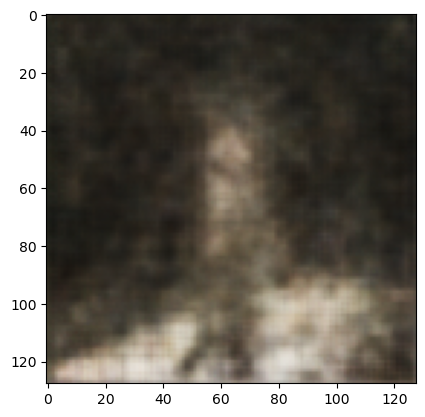

In [24]:
plt.imshow(x)

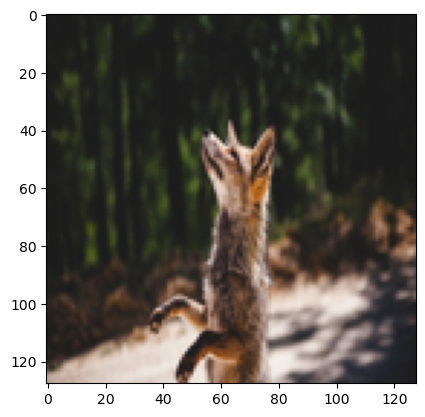

In [25]:
plt.imshow(images[0])